# Graphes en machine learning - énoncé

Ce notebook propose une série de graphes qu'on utilise fréquemment dans un notebook.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [139]:
import pyensae
%nb_menu

Le module utilise des données issues de [Wine Quality Data Set](https://archive.ics.uci.edu/ml/datasets/Wine+Quality) pour lequel on essaye de prédire la qualité du vin en fonction de ses caractéristiques chimiques.

In [4]:
import pyensae
pyensae.download_data("winequality-red.csv", url="https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/")
pyensae.download_data("winequality-white.csv", url="https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/")

'winequality-white.csv'

In [5]:
%head winequality-red.csv

In [6]:
import pandas
red_wine = pandas.read_csv("winequality-red.csv", sep=";")
red_wine["red"] = 1
white_wine = pandas.read_csv("winequality-white.csv", sep=";")
white_wine["red"] = 0
wines = pandas.concat([red_wine, white_wine])
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red
0,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,1


On découpe en base d'apprentissage, base de test :

In [7]:
from sklearn.cross_validation import train_test_split
X = wines[[c for c in wines.columns if c != "quality"]]
Y = wines["quality"]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
type(x_train), type(y_train)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [8]:
wines.shape, x_train.shape, y_train.shape

((6497, 13), (4352, 12), (4352,))

## Exploration

### histogrammes

fonction [hist](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.hist.html)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000ACD0E48>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000B11B6A0>]], dtype=object)

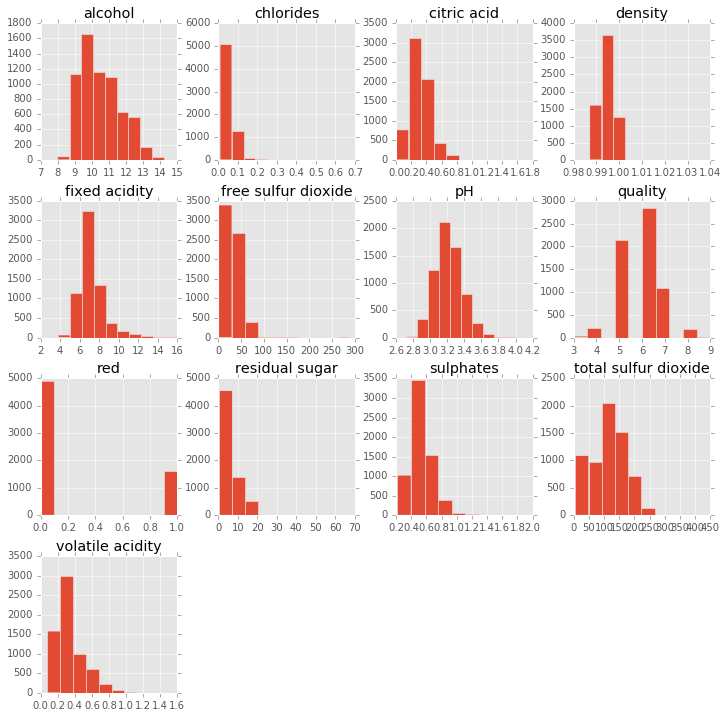

In [9]:
wines.hist(figsize=(12,12))

Et plus particulièrement :

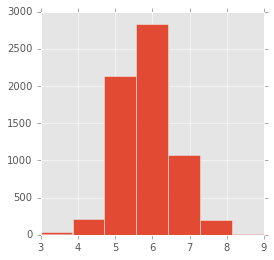

In [10]:
wines.quality.hist(bins=7, figsize=(4,4))

### événements rares

Les queues de distributions sont des événements rares. De même que dans cet échantillon, la classe 9 est très peu représentée (voir ci-dessous). Lorsqu'on découpe le jeu de données en base d'apprentissage et base de test, ces événements ne sont pas uniformément distribués. Il est très peu probable qu'un classifieur quelconque arrive à prédire la classe 9. Il faudra traiter cette classe séparément. 

Il est difficile de dire si un prédicteur doit éviter d'utiliser des événements rares ou des valeurs aberrantes mais il est difficile de prévoir si la prédiction est généralisable. On choisit parfois de nettoyer les bases de ces événements, en les supprimant, en les lissant, en changeant d'échelle avec une échelle logarithmique.

In [11]:
wines[["quality", "red"]].groupby("quality").count()

,red
quality,
3,30
4,216
5,2138
6,2836
7,1079
8,193
9,5


### corrélations

fonction [pairplot](https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.pairplot.html?highlight=pairplot#seaborn.pairplot)

c:\python34_x64\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
c:\python34_x64\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


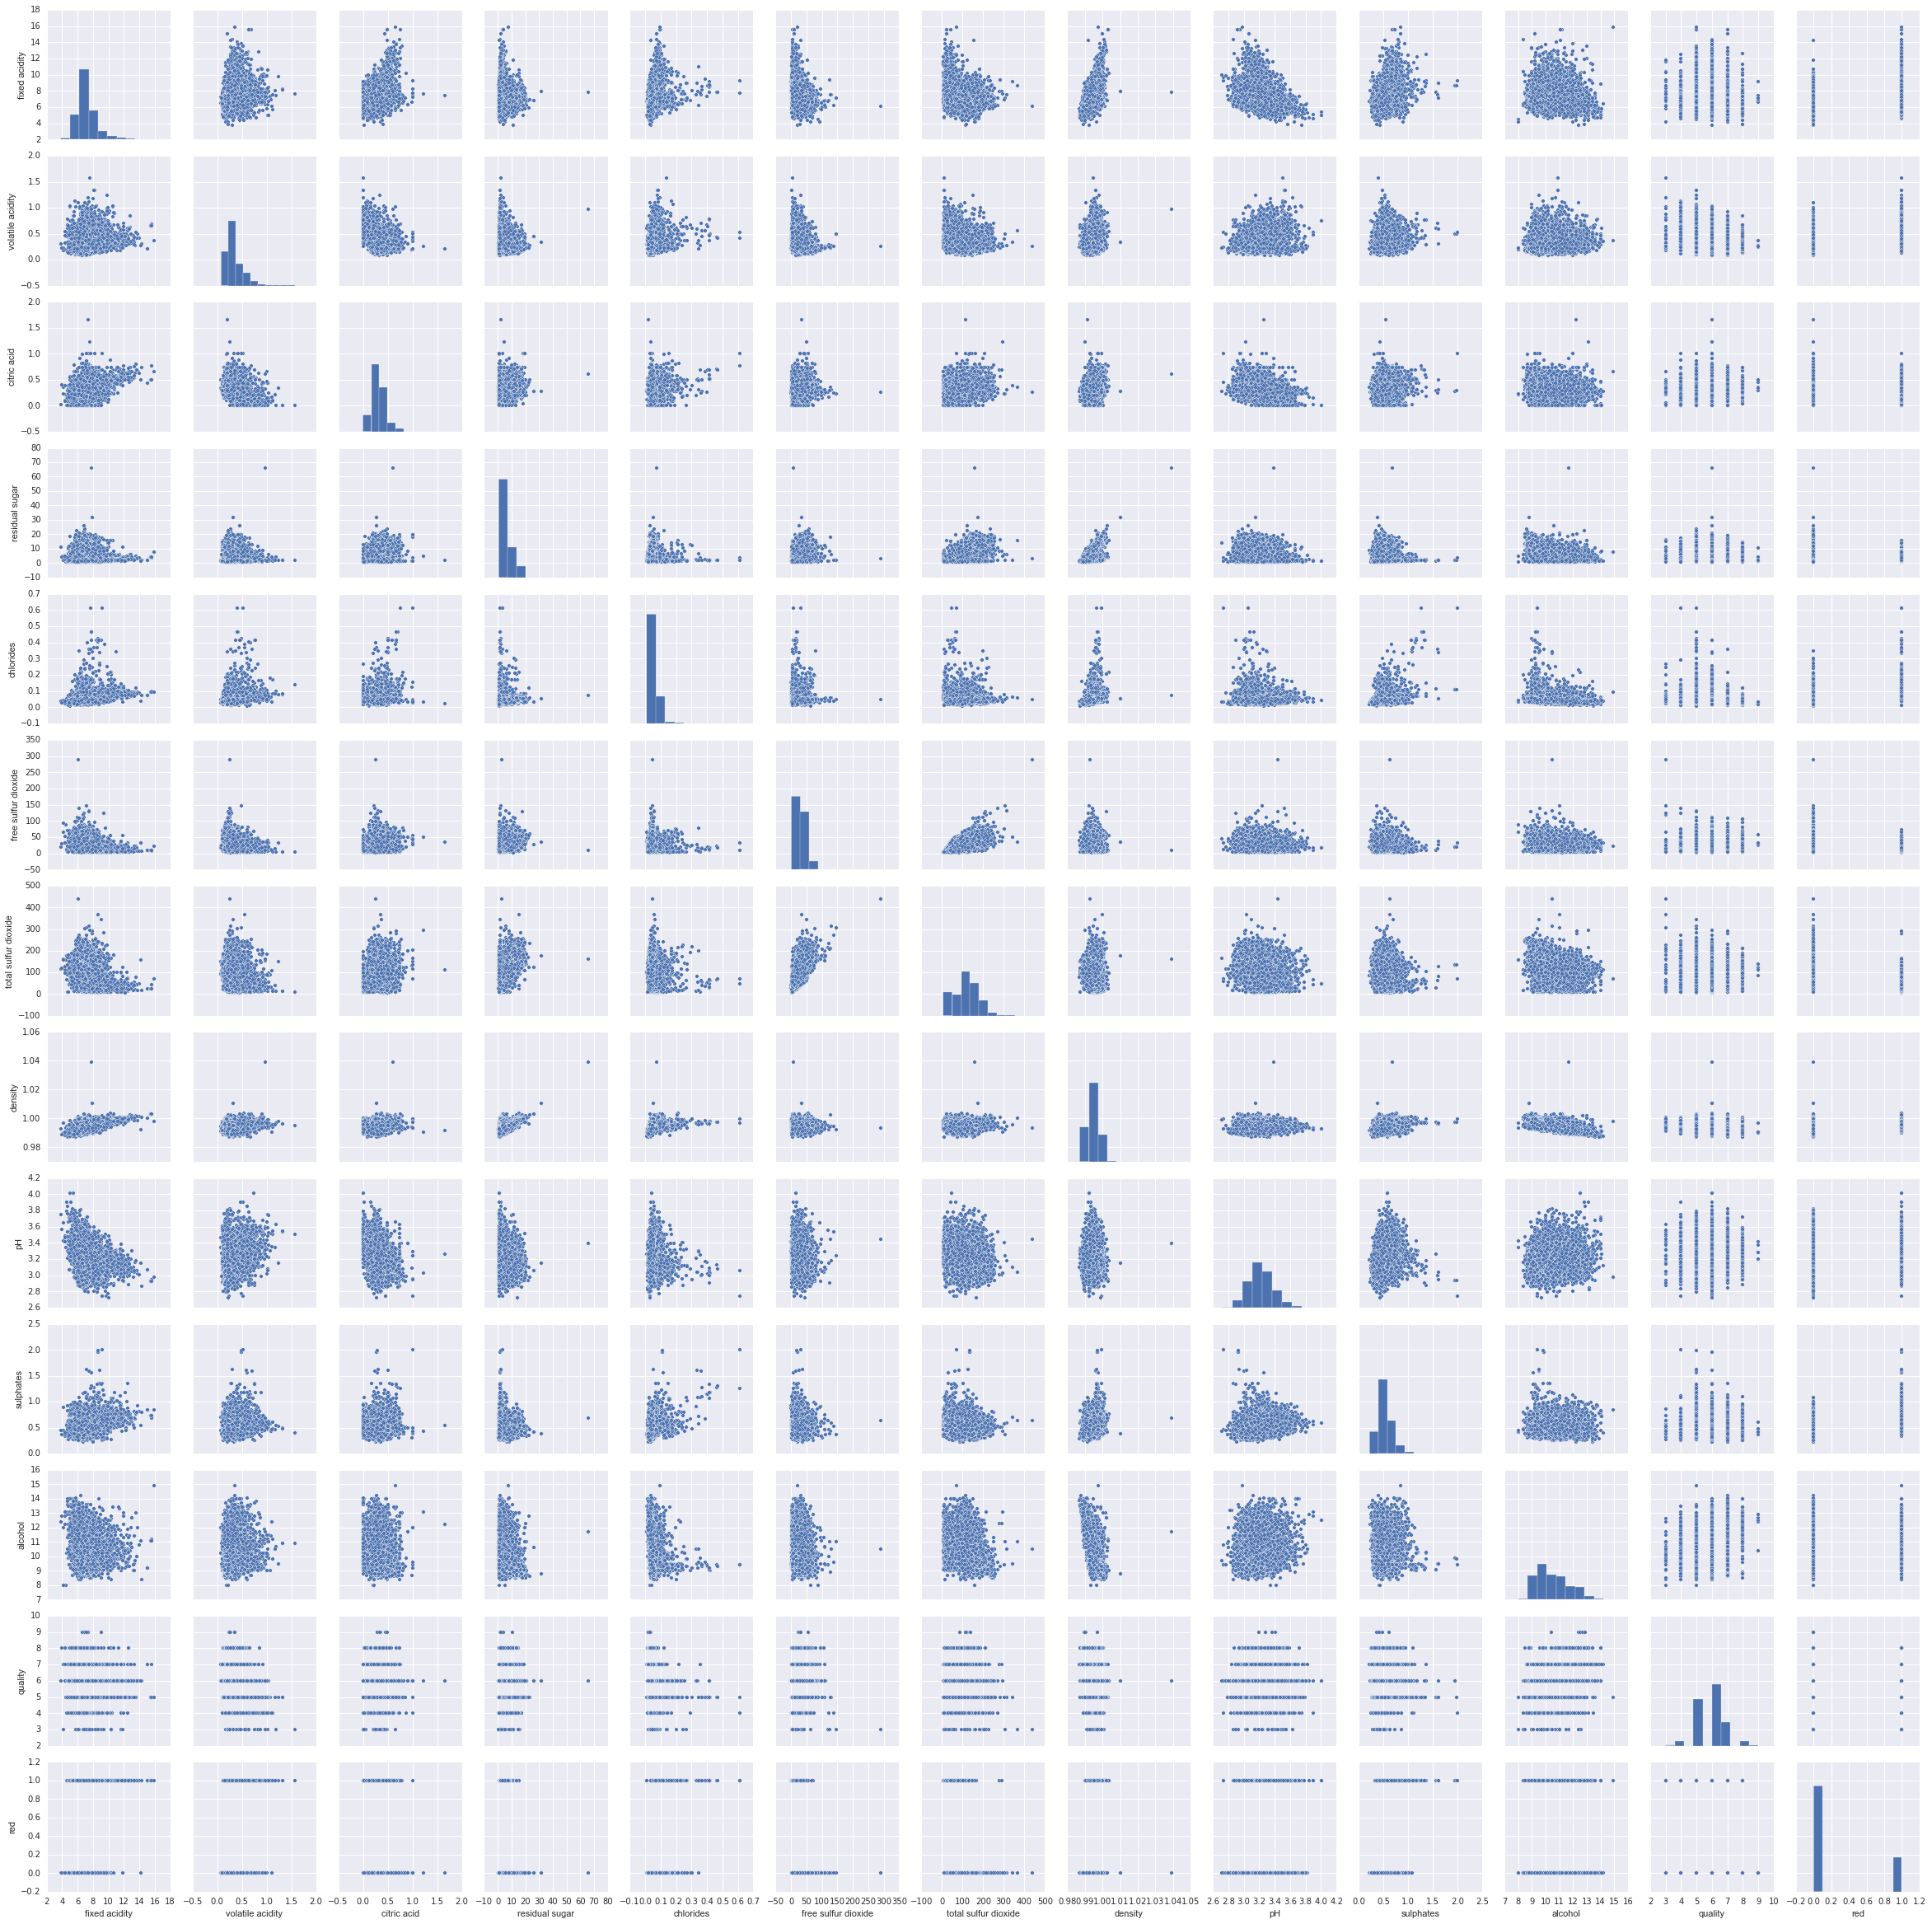

In [12]:
import seaborn
seaborn.pairplot(wines)

fonction [clustermap](https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.clustermap.html), plus pratique quand il y a beaucoup de variables

c:\python34_x64\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


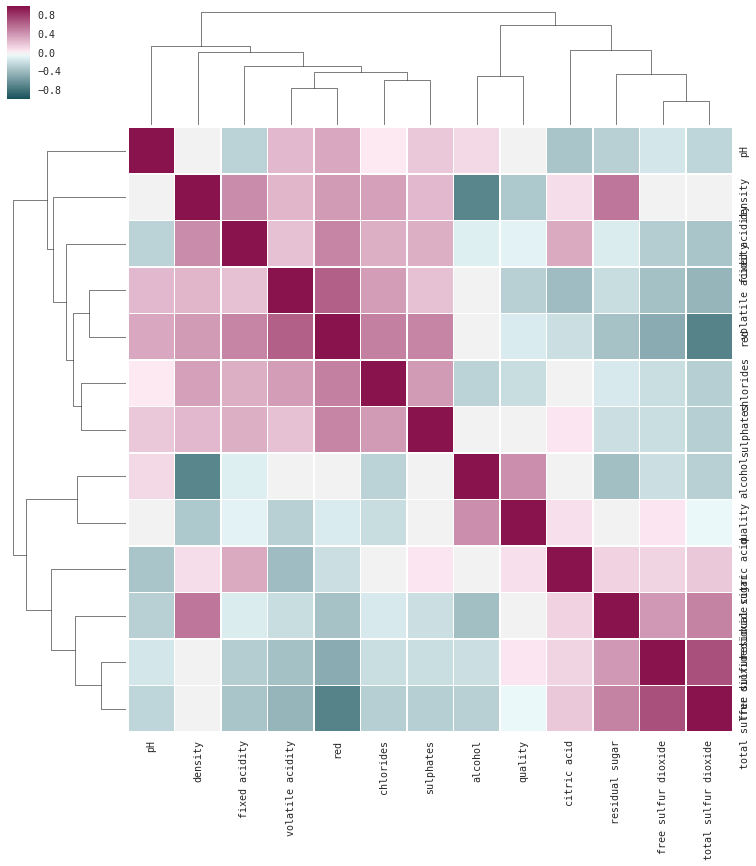

In [13]:
import seaborn
seaborn.set(font="monospace")
cmap = seaborn.diverging_palette(h_neg=210, h_pos=350, s=90, l=30, as_cmap=True)
seaborn.clustermap(wines.corr(), linewidths=.5, figsize=(13, 13), cmap=cmap)

## Classifieur

Pour le jeu [Wine Quality Data Set](https://archive.ics.uci.edu/ml/datasets/Wine+Quality), on essaye de prédire la note de l'expert qui est discrète et qui va de 1 à 9. On utilise l'exemple présent à la page [Decisions Trees](http://scikit-learn.org/stable/modules/tree.html) et un autre arbre de décision appris en faisant du boosting avec [AdaBoostClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html).

In [14]:
from sklearn import tree
clf1 = tree.DecisionTreeClassifier(min_samples_leaf=10, min_samples_split=10)
clf1.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=10,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [15]:
from sklearn.ensemble import AdaBoostClassifier
clf2 = AdaBoostClassifier(clf1,
                         algorithm='SAMME',
                         n_estimators=800,
                         learning_rate=0.5)
clf2.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=10,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best'),
          learning_rate=0.5, n_estimators=800, random_state=None)

On a besoin de spécifier le paramètre *min_samples_leaf* pour éviter de n'avoir qu'un élément dans chaque feuille de l'arbre. Ce n'est souvent pas très bon en terme de généralisation et l'arbre de décision retourne des probabilités de classification égale à 1 équivalent au ratio d'observations de la classe prédite dans cette feuille.

In [16]:
clf1.classes_, "nb classes", len(clf1.classes_)

(array([3, 4, 5, 6, 7, 8, 9], dtype=int64), 'nb classes', 7)

In [17]:
clf2.classes_, "nb classes", len(clf2.classes_)

(array([3, 4, 5, 6, 7, 8, 9], dtype=int64), 'nb classes', 7)

Il n'y a aucune note en desous de 3 ou au-dessus de 9 dans la base d'apprentissage.

### matrice de confusion

La matrice de confusion est très utilisée dans les problèmes multi-classes comme celui-ci. Elle donne une bonne indication de la pertinence du modèle. L'inconvénient est qu'elle ne tient pas compte du score retourné par le modèle.

avec la fonction [confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

In [18]:
from sklearn.metrics import confusion_matrix
y_pred = clf1.predict(x_test)
conf1 = confusion_matrix(y_test, y_pred)
conf1

array([[  0,   0,   4,   6,   0,   0,   0],
       [  0,   1,  38,  33,   4,   0,   0],
       [  0,   4, 388, 239,  40,   1,   0],
       [  0,   6, 271, 586, 110,   4,   0],
       [  0,   0,  40, 166, 141,   5,   0],
       [  0,   0,   4,  27,  20,   6,   0],
       [  0,   0,   0,   0,   1,   0,   0]])

In [19]:
y_pred = clf2.predict(x_test)
conf2 = confusion_matrix(y_test, y_pred)
conf2

array([[  1,   0,   5,   4,   0,   0,   0],
       [  2,  14,  47,  13,   0,   0,   0],
       [  1,  10, 497, 151,  12,   1,   0],
       [  0,   3, 191, 705,  71,   7,   0],
       [  0,   0,   6, 132, 208,   6,   0],
       [  0,   0,   0,  15,  23,  19,   0],
       [  0,   0,   0,   1,   0,   0,   0]])

On peut considérer la précision par classe : coefficient de la diagonale divissée par l'ensemble des poids de la même ligne. Ou la précision globale : somme des coefficients de la diagonale sur l'ensemble des coefficients. L'erreur correspond à *1-precision*.

In [20]:
[ conf1[i,i] / conf1[i,:].sum() for i in range(conf1.shape [0]) ]

[0.0,
 0.013157894736842105,
 0.57738095238095233,
 0.59979529170931423,
 0.40056818181818182,
 0.10526315789473684,
 0.0]

In [21]:
sum(conf1[i,i] for i in range(conf1.shape[0])) / conf1.sum()

0.52307692307692311

Et pour l'autre classifieur :

In [22]:
[ conf2[i,i] / conf2[i,:].sum() for i in range(conf2.shape [0]) ]

[0.10000000000000001,
 0.18421052631578946,
 0.73958333333333337,
 0.72159672466734903,
 0.59090909090909094,
 0.33333333333333331,
 0.0]

In [23]:
sum(conf2[i,i] for i in range(conf2.shape[0])) / conf2.sum()

0.67319347319347322

### courbe ROC avec decision_function

voir [plot_roc](http://scikit-learn.org/stable/auto_examples/plot_roc.html)

La courbe ROC est l'outil de référence pour comparer les performances de deux classifiers en tenant compte du score de confiance qu'il retourne.

On superpose deux courbes ROC obtenue pour deux classes différentes : un vin de la classe *A* est bien classée si le modèle prédit *A*, il est mal classé s'il ne prédit pas *A*. Tout d'abord une courbe ROC s'appuie sur le score que retourne le classifieur avec la méthode *decision_function* excepté lorsque le modèle en question ne l'implémente pas. On ruse un peu pour construire un score :

In [24]:
y_pred = clf2.predict(x_test)
y_prob = clf2.decision_function(x_test)
y_min = y_pred.min()
import numpy
y_score = numpy.array( [y_prob[i,p-y_min] for i,p in enumerate(y_pred)] ) 
y_score[:5], y_pred[:5], y_prob[:5,:]

(array([ 0.44695663,  0.5761366 ,  0.54780929,  0.45319441,  0.43242137]),
 array([6, 5, 7, 5, 5], dtype=int64),
 array([[ 0.0236264 ,  0.02534398,  0.09485579,  0.44695663,  0.260574  ,
          0.13367565,  0.01496753],
        [ 0.01119441,  0.08593269,  0.5761366 ,  0.28923019,  0.02877988,
          0.00872623,  0.        ],
        [ 0.        ,  0.00629089,  0.05027938,  0.13608143,  0.54780929,
          0.15774017,  0.10179883],
        [ 0.00370104,  0.04629901,  0.45319441,  0.42036501,  0.06138592,
          0.01258636,  0.00246825],
        [ 0.05268753,  0.22454205,  0.43242137,  0.22912309,  0.0463235 ,
          0.01490246,  0.        ]]))

On crée les courbes ROC pour chacune des classes :

In [25]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
nb_obs = dict()

for i in clf2.classes_:
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])
    nb_obs[i] = (y_test == i).sum()
    
roc_auc, nb_obs

({3: 0.22341920374707261,
  4: 0.32940525552644301,
  5: 0.58594280380176511,
  6: 0.47241345466272205,
  7: 0.48352652993966438,
  8: 0.41398635477582846,
  9: 0.39412313432835822},
 {3: 10, 4: 76, 5: 672, 6: 977, 7: 352, 8: 57, 9: 1})

On ajoute une dernière courbe ROC pour savoir si un élément est bien classé ou pas en balayant toutes les classes :

In [26]:
i = "all"
fpr[i], tpr[i], _ = roc_curve(y_test == y_pred, y_score)
roc_auc[i] = auc(fpr[i], tpr[i])
nb_obs[i] = (y_test == y_pred).sum()

roc_auc_best, nb_obs_best = roc_auc, nb_obs
roc_auc, nb_obs

({'all': 0.73270575078735956,
  3: 0.22341920374707261,
  4: 0.32940525552644301,
  5: 0.58594280380176511,
  6: 0.47241345466272205,
  7: 0.48352652993966438,
  8: 0.41398635477582846,
  9: 0.39412313432835822},
 {'all': 1444, 3: 10, 4: 76, 5: 672, 6: 977, 7: 352, 8: 57, 9: 1})

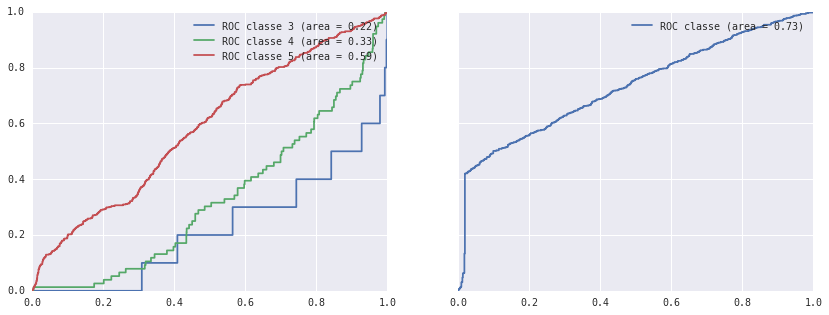

In [27]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2, figsize=(14,5), sharey=True)
for cl in (3,4,5):
    axes[0].plot(fpr[cl], tpr[cl], label='ROC classe %d (area = %0.2f)' % (cl, roc_auc[cl]))
for cl in ("all",):
    axes[1].plot(fpr[cl], tpr[cl], label='ROC classe (area = %0.2f)' % (roc_auc[cl]))
axes[0].legend()
axes[1].legend()

### courbe ROC avec predict_proba

voir [plot_roc](http://scikit-learn.org/stable/auto_examples/plot_roc.html), on l'applique à l'arbre de décision

In [28]:
y_pred = clf1.predict(x_test)
y_prob = clf1.predict_proba(x_test)
y_min = y_pred.min()
import numpy
y_score = numpy.array( [y_prob[i,p-y_min] for i,p in enumerate(y_pred)] ) 
y_score[:5]

array([ 0.        ,  0.1875    ,  0.38461538,  0.08333333,  0.26666667])

On crée les courbes ROC pour chacune des classes :

In [29]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
nb_obs = dict()

for i in clf1.classes_:
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])
    nb_obs[i] = (y_test == i).sum()
    
roc_auc, nb_obs

({3: 0.60826697892271664,
  4: 0.49646727379105082,
  5: 0.49087796608799661,
  6: 0.50763230675397142,
  7: 0.50412747807128744,
  8: 0.47085685958190493,
  9: 0.23297574626865669},
 {3: 10, 4: 76, 5: 672, 6: 977, 7: 352, 8: 57, 9: 1})

On ajoute une dernière courbe ROC pour savoir si un élément est bien classé ou pas :

In [30]:
i = "all"
fpr[i], tpr[i], _ = roc_curve(y_test == y_pred, y_score)
roc_auc[i] = auc(fpr[i], tpr[i])
nb_obs[i] = (y_test == y_pred).sum()

roc_auc, nb_obs

({'all': 0.47249927252514801,
  3: 0.60826697892271664,
  4: 0.49646727379105082,
  5: 0.49087796608799661,
  6: 0.50763230675397142,
  7: 0.50412747807128744,
  8: 0.47085685958190493,
  9: 0.23297574626865669},
 {'all': 1122, 3: 10, 4: 76, 5: 672, 6: 977, 7: 352, 8: 57, 9: 1})

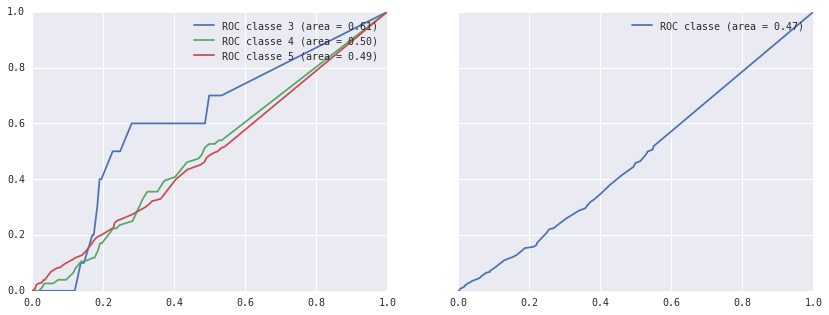

In [31]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2, figsize=(14,5), sharey=True)
for cl in (3,4,5):
    axes[0].plot(fpr[cl], tpr[cl], label='ROC classe %d (area = %0.2f)' % (cl, roc_auc[cl]))
for cl in ("all",):
    axes[1].plot(fpr[cl], tpr[cl], label='ROC classe (area = %0.2f)' % (roc_auc[cl]))
axes[0].legend()
axes[1].legend()

Voir également [scikit-learn for TMVA Users](http://betatim.github.io/posts/sklearn-for-TMVA-users/).

## Alternatives à la courbe ROC

### un peu plus sur la courbe de ROC

La courbe ROC est parfois difficile à interpréter. Tout d'abord, elle suppose qu'un classifieur retourne une classe et un score. Le score détermine la confiance du modèle en sa prévision. Une classifieur dessine une frontière autour de classe, plus on est loin de cette frontière, plus on est confiant. Sa confiance est proche de 1. A l'inverse, si on cherche à prédire la classe d'une observation proche de la frontière, le classifier n'est pas très confiance. Sa confiance est proche de 0.

Le coin supérieur de droit de la courbe ROC a pour coordonnées (1,1) : dans ce cas, on valide toutes les réponses du classifieur. On valide toutes ses erreurs (abscisse = 100%) et toutes ses bonnes réponses (ordonnée = 100%). Si on décide que le classifieur ne peut pas répondre pour un score < 0.5, on va rejetter un certain nombre de réponse : on fera moins d'erreurs (x=100%-40%) et moins de bonnes réponses (y=100%-10%). La courbe passera par point de coordonnées (0.6,0.9). La courbe ROC est construite en faisant varier le seuil de validation des réponses du classifieur.

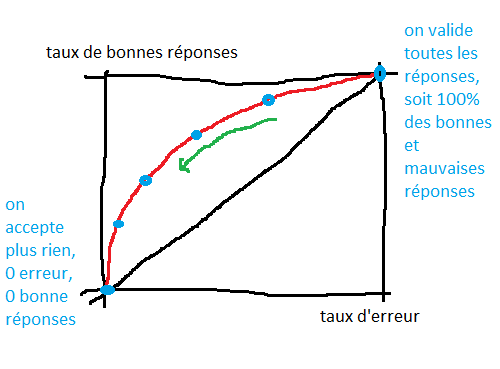

In [32]:
from pyquickhelper.helpgen import NbImage
NbImage("roc_ex.png")

Chaque point de la courbe est obtenu pour un seuil différent. Le seuil augmente (on valide moins de réponses) dans le sens de la flèche verte. Si le score d'un classifieur est pertinent, le nombre d'erreurs baisse plus vite que le nombre de bonnes réponses. Si le score n'est pas pertinent, la courbe ROC est proche de la diagonale. Lorsque le seuil de validation augmente, le ratio erreur sur bonnes réponses ne change pas.

### AUC

L'AUC ou [Area Under the Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) est l'aire sous la courbe ROC. Pour un classifieur binaire, si elle est égale à 0.5, cela signifie que le score classifieur ne donne aucune indication sur la qualité de la réponse (il est aléatoire). En-dessous, il y a probablement une erreur. L'AUC vérifie une autre propriété. Soit le score $p(x_1)$ le score d'une bonne réponse et $n(x_2)$ le score d'une mauvaise réponse, alors :

$\mathbb{P}(p(x_1) > n(x_2)) = AUC$

Autrement dit, la probabilité que le score d'une bonne réponse soit supérieure au score d'une mauvaise réponse est égale à l'AUC ([démonstration](http://www.xavierdupre.fr/site2013/documents/reports/roc.pdf)).

### distribution des scores

Pour illustrer cette AUC de façon différente, on peut tracer la distribution des scores pour les bonnes et les mauvaises réponses.

In [100]:
from sklearn.ensemble import AdaBoostClassifier
clft = tree.DecisionTreeClassifier(min_samples_leaf=10, min_samples_split=10)
clfD = AdaBoostClassifier(clft,
                         algorithm='SAMME',
                         n_estimators=800,
                         learning_rate=0.5)
clfD.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=10,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best'),
          learning_rate=0.5, n_estimators=800, random_state=None)

In [101]:
from sklearn.metrics import auc, precision_recall_curve

y_predD = clfD.predict(x_test)
y_probD = clfD.predict_proba(x_test)
y_testn = y_test.as_matrix()
y_minD = y_predD.min()
import numpy
y_scoreD = numpy.array( [y_probD[i,p-y_minD] for i,p in enumerate(y_predD)] )
y_scoreD[:5]

array([ 0.15003339,  0.15281823,  0.15196125,  0.1505189 ,  0.15000208])

In [102]:
positive_scores = y_scoreD[y_testn == y_predD]
negative_scores = y_scoreD[y_testn != y_predD]

In [103]:
positive_scores.shape, negative_scores.shape

((1430,), (715,))

In [104]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
nb_obs = dict()

for i in clfD.classes_:
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])
    nb_obs[i] = (y_test == i).sum()
    
roc_auc, nb_obs

({3: 0.60826697892271664,
  4: 0.49646727379105082,
  5: 0.49087796608799661,
  6: 0.50763230675397142,
  7: 0.50412747807128744,
  8: 0.47085685958190493,
  9: 0.23297574626865669},
 {3: 10, 4: 76, 5: 672, 6: 977, 7: 352, 8: 57, 9: 1})

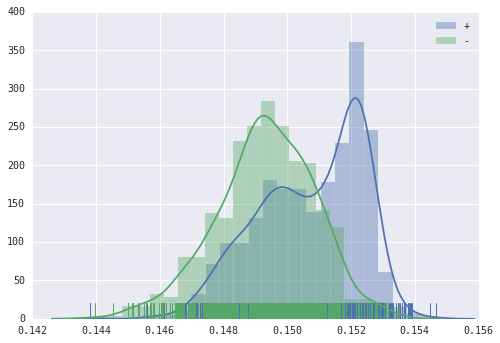

In [105]:
import seaborn
ax = seaborn.distplot(positive_scores, rug=True, hist=True, label="+")
seaborn.distplot(negative_scores, rug=True, hist=True, ax=ax, label="-")
ax.legend()

Le score de ce modèle n'est pas des plus discriminants puisqu'il existe une aire commune assez importante.

### taux de rappel et précision

Les taux de [rappel et de précision](https://fr.wikipedia.org/wiki/Pr%C3%A9cision_et_rappel) (precision recall) sont très utilisés en classification. Pour un seuil donné, la précision mesure le taux de réponse parmi les réponses validées (donc ayant un score au-dessus du seuil choisi), le taux de rappel mesure le taux de réponse validées.

La dénomination ``vrai positif``, ``faux positif``, ... est assez trompeuse. Comme le classifieur retourne un score de confiance, on décide de valider ou de rejeter sa réponse si le score est supérieur ou inférieur à ce seuil :

* si *score >= seuil*, on valide la réponse, qui est soit bonne (*TP : True Positive*), soit fausse (*FP : False Positive*)
* si *score < seuil*, on rejete la réponse qui est soit bonne (*FN : False Negative*) soit fausse (*TN : True Negative*)

La présicion est définie comme étant le nombre de réponses justes sur le nombre de réponses validées :

$precision = \frac{TP}{TP + FP}$ et $rappel = \frac{TP}{TP + FN}$

On utilise la fonction [precision_recall_curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html).

In [35]:
from sklearn.ensemble import AdaBoostClassifier
clft = tree.DecisionTreeClassifier(min_samples_leaf=10, min_samples_split=10)
clf4 = AdaBoostClassifier(clft,
                         algorithm='SAMME',
                         n_estimators=800,
                         learning_rate=0.5)
clf4.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=10,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best'),
          learning_rate=0.5, n_estimators=800, random_state=None)

In [36]:
from sklearn.metrics import auc, precision_recall_curve

y_pred4 = clf4.predict(x_test)
y_prob4 = clf4.predict_proba(x_test)
y_min4 = y_pred4.min()
import numpy
y_score4 = numpy.array( [y_prob4[i,p-y_min4] for i,p in enumerate(y_pred4)] )
y_score4[:5]

precision = dict()
recall = dict()
threshold = dict()
nb_obs = dict()

for i in clf4.classes_:
    precision[i], recall[i], threshold[i] = precision_recall_curve(y_test == i, y_score4)
    nb_obs[i] = (y_test == i).sum()

i = "all"
precision[i], recall[i], threshold[i] = precision_recall_curve(y_test == y_pred4, y_score4)
nb_obs[i] = (y_test == y_pred4).sum()

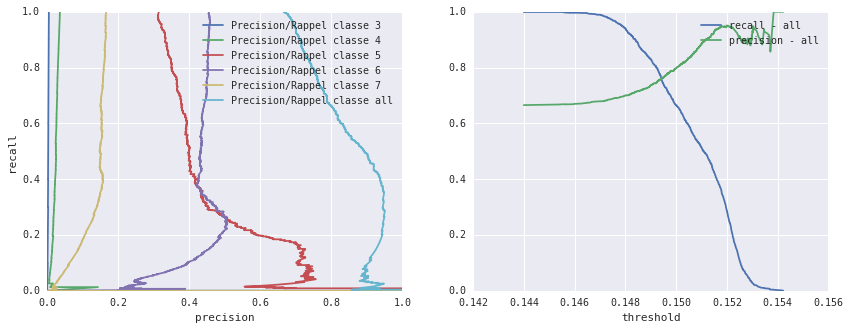

In [37]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2, figsize=(14,5))
for cl in (3,4,5,6,7,'all'):
    axes[0].plot(precision[cl], recall[cl], label='Precision/Rappel classe %s' % str(cl))
cl = 'all'
axes[1].plot(threshold[cl], recall[cl][1:], label='recall - all')
axes[1].plot(threshold[cl], precision[cl][1:], label='precision - all')
axes[1].set_xlabel("threshold")
axes[0].set_xlabel("precision")
axes[0].set_ylabel("recall")
axes[0].legend()
axes[1].legend()

Il paraît difficile de faire montrer la précision dans baisser beaucoup le rappel. Cette courbe est inconsistance lorsque le rappel est très bas car la précision est estimée sur peu d'observations.

## Régression

In [106]:
from sklearn import linear_model
clr1 = linear_model.LinearRegression()
clr1.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [107]:
from sklearn import tree
clr2 = tree.DecisionTreeRegressor(min_samples_leaf=10)
clr2.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=None,
           splitter='best')

### cross validation

In [108]:
from sklearn.cross_validation import cross_val_score
cross_val_score(clr1, x_train, y_train, cv=10)

array([ 0.29336767,  0.31460783,  0.3111648 ,  0.30226155,  0.28286758,
        0.33354088,  0.28893078,  0.21155669,  0.29534698,  0.36294567])

In [109]:
cross_val_score(clr2, x_train, y_train, cv=10)

array([ 0.2241499 ,  0.21794546,  0.29056047,  0.25820521,  0.19707314,
        0.29504697,  0.28721334,  0.18737899,  0.20608564,  0.31439576])

### réprésentation des erreurs

Difficile de représentation des erreurs lorsque le problème est à plusieurs dimensions. On trie les erreurs de façon croissante.

In [110]:
y_pred = clr1.predict(x_test)
diff1 = (y_test * 1.0 - y_pred).sort_values()
diff1.head()

4745   -3.862356
3307   -3.577666
740    -3.338887
3087   -2.784958
652    -2.782309
Name: quality, dtype: float64

In [111]:
y_pred = clr2.predict(x_test)
diff2 = (y_test * 1.0 - y_pred).sort_values()
diff2.head()

2050   -3.600000
3087   -2.800000
2159   -2.727273
1505   -2.700000
2225   -2.500000
Name: quality, dtype: float64

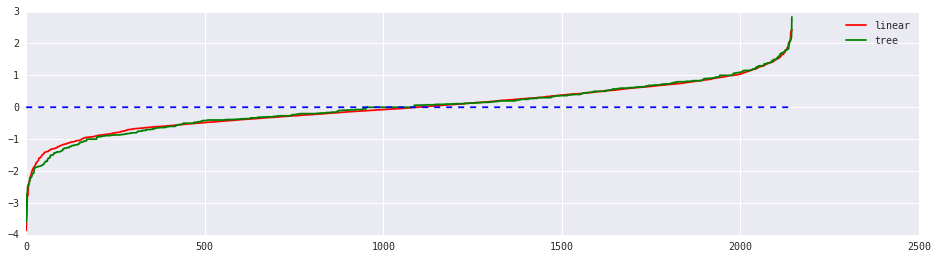

In [112]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,1, figsize=(16,4))
axes.plot(list(range(len(diff1))), list(diff1),"r-", markersize = 3, label="linear")
axes.plot(list(range(len(diff2))), list(diff2),"g-", markersize = 3, label="tree")
axes.plot(list(range(len(diff1))), [0 for i in range(len(diff1))], "b--")
axes.legend()

L'erreur est reliée à l'aire sous la courbe.

### régression 1d et tendance

In [113]:
x_train1d = x_train.copy()
x_train1d["const"] = 1.0
train_1d = x_train1d[["alcohol","const", "residual sugar"]]
train_1d.head()

,alcohol,const,residual sugar
101,9.4,1,9.6
3600,9.9,1,12.9
1741,12.9,1,2.0
86,9.9,1,1.9
3988,11.4,1,1.6


In [114]:
from sklearn import linear_model
clr = linear_model.LinearRegression()
clr.fit(train_1d[["const", "alcohol"]], train_1d["residual sugar"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [115]:
pred = clr.predict(train_1d[["const", "alcohol"]])
graph = train_1d.copy()
graph["trend"] = pred
graph.head()

,alcohol,const,residual sugar,trend
101,9.4,1,9.6,7.019617
3600,9.9,1,12.9,6.301488
1741,12.9,1,2.0,1.992719
86,9.9,1,1.9,6.301488
3988,11.4,1,1.6,4.147104


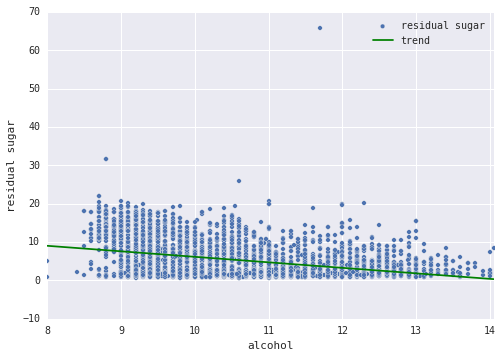

In [116]:
ax = graph.plot(x="alcohol", y="residual sugar", kind="scatter", label="residual sugar")
graph.sort_values("alcohol").plot(x="alcohol", y="trend", ax=ax, color="green", label="trend")

On peut aussi jouer avec la fonction [add_trend](http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.tsatools.add_trend.html) de [statsmodels](http://statsmodels.sourceforge.net/devel/index.html).

### Exercice 1 : créer une fonction pour automatiser la création de ce graphe

## Autres variantes

### On agrège les classes 8 et 9, 3 et 4

On agrége ces classes pour lesquels on manque d'observations.

In [117]:
y_train89 = y_train.copy()
y_test89 = y_test.copy()
y_train89[y_train89==9] = 8
y_test89[y_test89==9] = 8
y_train89[y_train89==3] = 4
y_test89[y_test89==3] = 4

In [118]:
from sklearn.ensemble import AdaBoostClassifier
clft = tree.DecisionTreeClassifier(min_samples_leaf=10, min_samples_split=10)
clf89 = AdaBoostClassifier(clft,
                         algorithm='SAMME',
                         n_estimators=800,
                         learning_rate=0.5)
clf89.fit(x_train, y_train89)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=10,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best'),
          learning_rate=0.5, n_estimators=800, random_state=None)

In [119]:
from sklearn.metrics import confusion_matrix
y_pred = clf89.predict(x_test)
conf89 = confusion_matrix(y_test89, y_pred)
conf89

array([[ 18,  46,  22,   0,   0],
       [ 14, 482, 166,  10,   0],
       [  6, 195, 697,  73,   6],
       [  0,   3, 138, 205,   6],
       [  1,   0,  15,  22,  20]])

In [120]:
from sklearn.metrics import roc_curve, auc

y_pred89 = clf89.predict(x_test)
y_prob89 = clf89.predict_proba(x_test)
y_min89 = y_pred89.min()
import numpy
y_score89 = numpy.array( [y_prob89[i,p-y_min89] for i,p in enumerate(y_pred89)] ) 
y_score89[:5]

fpr = dict()
tpr = dict()
roc_auc = dict()
nb_obs = dict()

for i in clf89.classes_:
    fpr[i], tpr[i], _ = roc_curve(y_test89 == i, y_score89)
    roc_auc[i] = auc(fpr[i], tpr[i])
    nb_obs[i] = (y_test89 == i).sum()
    
i = "all"
fpr[i], tpr[i], _ = roc_curve(y_test89 == y_pred89, y_score89)
roc_auc[i] = auc(fpr[i], tpr[i])
nb_obs[i] = (y_test89 == y_pred89).sum()    
    
roc_auc, nb_obs

({4: 0.31156748026248915,
  5: 0.62036599262923098,
  6: 0.47779581049059877,
  7: 0.43688206662272477,
  8: 0.32977958792525164,
  'all': 0.7353434373498452},
 {4: 86, 5: 672, 6: 977, 7: 352, 8: 58, 'all': 1422})

A comparer avec le meilleur classifieur :

In [121]:
roc_auc_best, nb_obs_best

({'all': 0.73270575078735956,
  3: 0.22341920374707261,
  4: 0.32940525552644301,
  5: 0.58594280380176511,
  6: 0.47241345466272205,
  7: 0.48352652993966438,
  8: 0.41398635477582846,
  9: 0.39412313432835822},
 {'all': 1444, 3: 10, 4: 76, 5: 672, 6: 977, 7: 352, 8: 57, 9: 1})

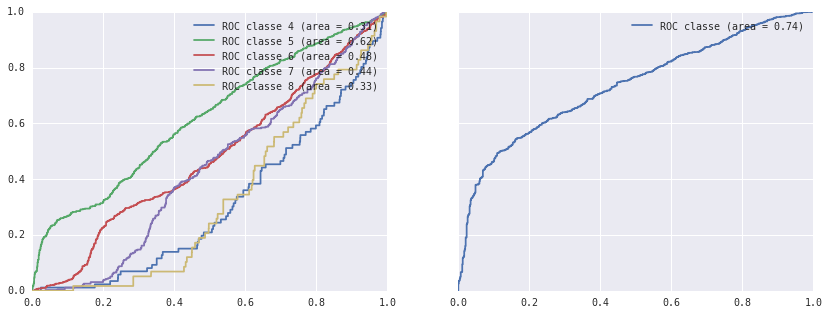

In [122]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2, figsize=(14,5), sharey=True)
for cl in (4,5,6,7,8):
    axes[0].plot(fpr[cl], tpr[cl], label='ROC classe %d (area = %0.2f)' % (cl, roc_auc[cl]))
for cl in ("all",):
    axes[1].plot(fpr[cl], tpr[cl], label='ROC classe (area = %0.2f)' % (roc_auc[cl]))
axes[0].legend()
axes[1].legend()

### On normalise les features

Même si cette méthode n'apporte pas grand chose dans ce cas, la normalisation par logarithme aide le classifieur lorsque les distributions ont des queues épaisses ou des points aberrants : cela donne moins d'importance aux événements extrêmes.

In [123]:
import math
x_train_n = x_train.copy()
x_test_n = x_test.copy()
x_train_n = x_train_n.applymap(lambda x: math.log(1+x))
x_test_n = x_test_n.applymap(lambda x: math.log(1+x))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000005FB199E8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000063EB8BA8>]], dtype=object)

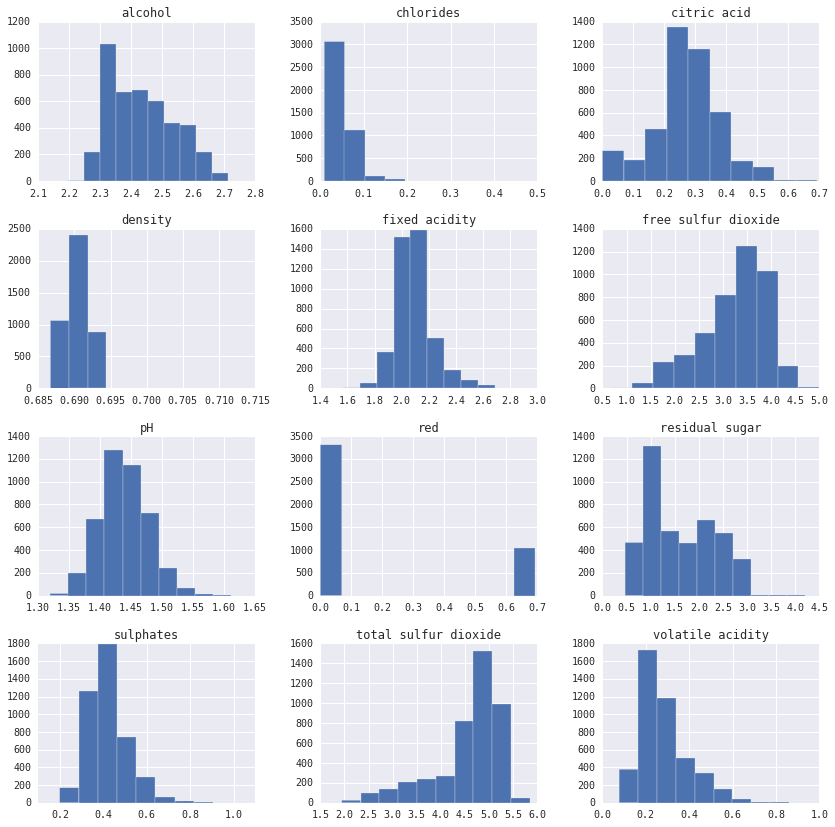

In [124]:
x_train_n.hist(figsize=(14,14))

In [125]:
from sklearn.ensemble import AdaBoostClassifier
clft = tree.DecisionTreeClassifier(min_samples_leaf=10, min_samples_split=10)
clfn = AdaBoostClassifier(clft,
                         algorithm='SAMME',
                         n_estimators=800,
                         learning_rate=0.5)
clfn.fit(x_train_n, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=10,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best'),
          learning_rate=0.5, n_estimators=800, random_state=None)

In [126]:
from sklearn.metrics import confusion_matrix
y_predn = clfn.predict(x_test_n)
confn = confusion_matrix(y_test, y_predn)
confn

array([[  1,   0,   5,   4,   0,   0,   0],
       [  2,  15,  45,  14,   0,   0,   0],
       [  1,   8, 495, 156,  11,   1,   0],
       [  0,   2, 201, 697,  72,   5,   0],
       [  0,   0,   4, 140, 202,   6,   0],
       [  0,   0,   0,  17,  21,  19,   0],
       [  0,   0,   0,   1,   0,   0,   0]])

In [127]:
from sklearn.metrics import roc_curve, auc

y_predn = clfn.predict(x_test_n)
y_probn = clfn.predict_proba(x_test_n)
y_minn = y_predn.min()
import numpy
y_scoren = numpy.array( [y_probn[i,p-y_minn] for i,p in enumerate(y_predn)] ) 
y_scoren[:5]

fpr = dict()
tpr = dict()
roc_auc = dict()
nb_obs = dict()

for i in clfn.classes_:
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_scoren)
    roc_auc[i] = auc(fpr[i], tpr[i])
    nb_obs[i] = (y_test == i).sum()
    
i = "all"
fpr[i], tpr[i], _ = roc_curve(y_test == y_predn, y_scoren)
roc_auc[i] = auc(fpr[i], tpr[i])
nb_obs[i] = (y_test == y_predn).sum()    
    
roc_auc, nb_obs

({'all': 0.73318011579766296,
  3: 0.26341920374707262,
  4: 0.30935997557935441,
  5: 0.61732817702776965,
  6: 0.48250427644031912,
  7: 0.43527623206408761,
  8: 0.3348919473012032,
  9: 0.19916044776119401},
 {'all': 1429, 3: 10, 4: 76, 5: 672, 6: 977, 7: 352, 8: 57, 9: 1})

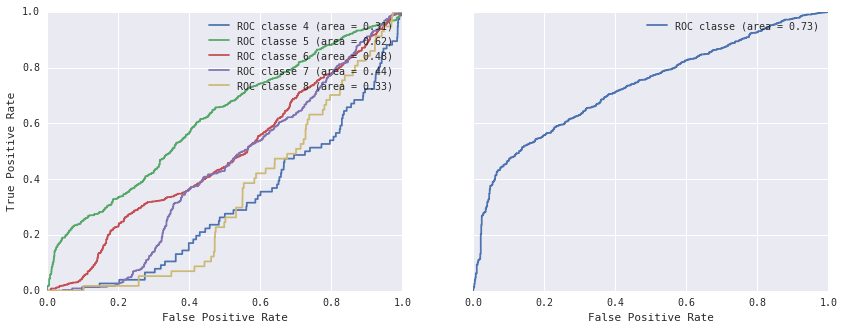

In [128]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2, figsize=(14,5), sharey=True)
for cl in (4,5,6,7,8):
    axes[0].plot(fpr[cl], tpr[cl], label='ROC classe %d (area = %0.2f)' % (cl, roc_auc[cl]))
for cl in ("all",):
    axes[1].plot(fpr[cl], tpr[cl], label='ROC classe (area = %0.2f)' % (roc_auc[cl]))
axes[0].legend()
axes[1].legend()
axes[0].set_ylabel("True Positive Rate")
axes[0].set_xlabel("False Positive Rate")
axes[1].set_xlabel("False Positive Rate")

### Classifieur pour les classes 8-9

In [129]:
y_trains89 = y_train.copy()
y_tests89 = y_test.copy()
y_trains89[y_trains89==9] = 8
y_tests89[y_tests89==9] = 8
y_trains89[y_trains89!=8] = 0
y_trains89[y_trains89==8] = 1
y_tests89[y_tests89!=8] = 0
y_tests89[y_tests89==8] = 1
set(y_tests89)

{0, 1}

In [130]:
from sklearn.naive_bayes  import GaussianNB
clfs89 = GaussianNB()
clfs89.fit(x_train, y_trains89)

GaussianNB()

In [131]:
from sklearn.metrics import confusion_matrix
y_pred = clfs89.predict(x_test)
confs89 = confusion_matrix(y_tests89, y_pred)
confs89

array([[1879,  208],
       [  27,   31]])

In [132]:
from sklearn.metrics import roc_curve, auc

y_preds89 = clfs89.predict(x_test)
y_probs89 = clfs89.predict_proba(x_test)
y_mins89 = y_preds89.min()
import numpy
y_scores89 = numpy.array( [y_probs89[i,p-y_mins89] for i,p in enumerate(y_preds89)] ) 
y_scores89[:5]

fpr = dict()
tpr = dict()
roc_auc = dict()
nb_obs = dict()

for i in clfs89.classes_:
    fpr[i], tpr[i], _ = roc_curve(y_tests89 == i, y_scores89)
    roc_auc[i] = auc(fpr[i], tpr[i])
    nb_obs[i] = (y_tests89 == i).sum()
    
i = "all"
fpr[i], tpr[i], _ = roc_curve(y_tests89 == y_preds89, y_scores89)
roc_auc[i] = auc(fpr[i], tpr[i])
nb_obs[i] = (y_tests89 == y_preds89).sum()    
    
roc_auc, nb_obs

({0: 0.75624969020041966, 1: 0.24375030979958029, 'all': 0.87251643087891273},
 {0: 2087, 1: 58, 'all': 1910})

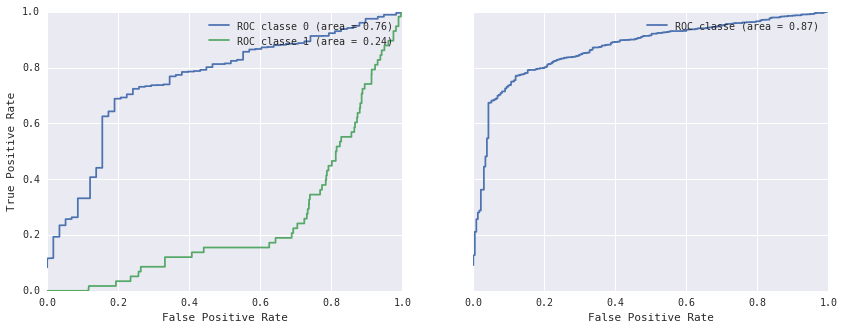

In [133]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2, figsize=(14,5), sharey=True)
for cl in (0,1):
    axes[0].plot(fpr[cl], tpr[cl], label='ROC classe %d (area = %0.2f)' % (cl, roc_auc[cl]))
for cl in ("all",):
    axes[1].plot(fpr[cl], tpr[cl], label='ROC classe (area = %0.2f)' % (roc_auc[cl]))
axes[0].legend()
axes[1].legend()
axes[0].set_ylabel("True Positive Rate")
axes[0].set_xlabel("False Positive Rate")
axes[1].set_xlabel("False Positive Rate")

## Autre module XGBoost

Le module [XGBoost](http://xgboost.readthedocs.org/en/latest/python) est utilisé dans la plupart des compétitions [Kaggle](https://www.kaggle.com/).

In [134]:
import xgboost

In [135]:
clxg = xgboost.XGBClassifier(max_depth=10, min_child_weight=5, nthread=3, n_estimators=800)
clxg.fit(x_train, y_train)

XGBClassifier(base_score=0.5, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=5, missing=None,
       n_estimators=800, nthread=3, objective='multi:softprob', seed=0,
       silent=True, subsample=1)

In [136]:
from sklearn.metrics import confusion_matrix
y_pred = clxg.predict(x_test)
confxg = confusion_matrix(y_test, y_pred)
confxg

array([[  0,   0,   4,   6,   0,   0,   0],
       [  2,  15,  43,  16,   0,   0,   0],
       [  2,  11, 463, 181,  14,   1,   0],
       [  1,   8, 206, 670,  87,   5,   0],
       [  0,   0,   9, 141, 197,   5,   0],
       [  0,   0,   0,  18,  20,  19,   0],
       [  0,   0,   0,   1,   0,   0,   0]])

In [137]:
from sklearn.metrics import roc_curve, auc

y_predxg = clxg.predict(x_test)
y_probxg = clxg.predict_proba(x_test)
y_minxg = y_predxg.min()
import numpy
y_scorexg = numpy.array( [y_probxg[i,p-y_minxg] for i,p in enumerate(y_predxg)] ) 
y_scorexg[:5]

fpr = dict()
tpr = dict()
roc_auc = dict()
nb_obs = dict()

for i in clxg.classes_:
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_scorexg)
    roc_auc[i] = auc(fpr[i], tpr[i])
    nb_obs[i] = (y_test == i).sum()
    
i = "all"
fpr[i], tpr[i], _ = roc_curve(y_test == y_predxg, y_scorexg)
roc_auc[i] = auc(fpr[i], tpr[i])
nb_obs[i] = (y_test == y_predxg).sum()    
    
roc_auc, nb_obs

({'all': 0.72186712651274221,
  3: 0.35222482435597186,
  4: 0.3824565643204193,
  5: 0.58408697830795586,
  6: 0.46124169248888824,
  7: 0.48845811362368807,
  8: 0.41878402903811252,
  9: 0.30550373134328357},
 {'all': 1364, 3: 10, 4: 76, 5: 672, 6: 977, 7: 352, 8: 57, 9: 1})

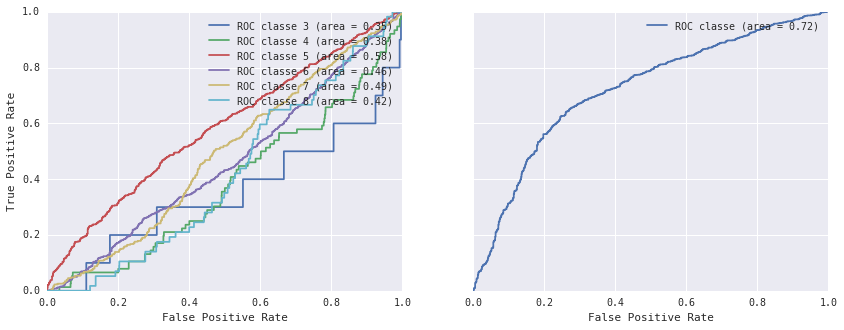

In [138]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2, figsize=(14,5), sharey=True)
for cl in (3,4,5,6,7,8):
    axes[0].plot(fpr[cl], tpr[cl], label='ROC classe %d (area = %0.2f)' % (cl, roc_auc[cl]))
for cl in ("all",):
    axes[1].plot(fpr[cl], tpr[cl], label='ROC classe (area = %0.2f)' % (roc_auc[cl]))
axes[0].legend()
axes[1].legend()
axes[0].set_ylabel("True Positive Rate")
axes[0].set_xlabel("False Positive Rate")
axes[1].set_xlabel("False Positive Rate")

## Exercice 2 : simplifier l'apprentissage  de chaque modèle

## Exercice 3 : grid_search

Considérer un modèle et estimer au mieux ses paramètres.